# Clustering analysis

Here we apply K-means clustering to segment the images of Eberswalde fan. We want to see how well this simple method can do for segmenting the images and identify some ideal parameters that perform best.

In [1]:
import rioxarray as rxr
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Path to your working directory to store the images
data_path = "/Users/tthomas/Desktop/ESS569/MLGEO2024_MarsFans/data/ai_ready/" # This is an example, change it to your own path

In [2]:
blendDEM = rxr.open_rasterio(data_path + "blendDEM_aiready.tif", cache=False)
blendSLOPE = rxr.open_rasterio(data_path + "blendSLOPE_aiready.tif", cache=False)

ctxDEM = rxr.open_rasterio(data_path + "ctxDEM_aiready.tif", cache=False)
ctxIMG = rxr.open_rasterio(data_path + "ctxIMG_aiready.tif", cache=False)
ctxSLOPE = rxr.open_rasterio(data_path + "ctxSLOPE_aiready.tif", cache=False)

dayIR = rxr.open_rasterio(data_path + "dayIR_aiready.tif", cache=False)
nightIR = rxr.open_rasterio(data_path + "nightIR_aiready.tif", cache=False)

hrscND = rxr.open_rasterio(data_path + "hrscND_aiready.tif", cache=False)
hrscP1 = rxr.open_rasterio(data_path + "hrscP1_aiready.tif", cache=False)
hrscP2 = rxr.open_rasterio(data_path + "hrscP2_aiready.tif", cache=False)
hrscS1 = rxr.open_rasterio(data_path + "hrscS1_aiready.tif", cache=False)
hrscS2 = rxr.open_rasterio(data_path + "hrscS2_aiready.tif", cache=False)

training_imgs = [blendDEM, blendSLOPE, ctxDEM, ctxIMG, ctxSLOPE, dayIR, nightIR, hrscND, hrscP1, hrscP2, hrscS1, hrscS2]
training_names = ['blendDEM', 'blendSLOPE', 'ctxDEM', 'ctxIMG', 'ctxSLOPE', 'dayIR', 'nightIR', 'hrscND', 'hrscP1', 'hrscP2', 'hrscS1', 'hrscS2']

## Approach

Ideally we want to do a clustering analysis across a variety of methods and with a variety of hyper parameters. Here we will start with K-means. There two main things we can tune here: the number of clusters to choose and the images to include. Let's try to optimize these.

### First, lets do a K-means cluster analysis on each image by itself

Choose 5 as the number of features because it matches the number of features in the label map for a start.

In [3]:
# Define the number of clusters
n_clusters = 5  # Adjust this number based on the desired number of feature classes

# Function to apply K-Means clustering to an image
def apply_kmeans(image, n_clusters):
    # Flatten the image into a 2D array where each row represents a pixel
    pixels = image.values[0].reshape(-1, 1)
    
    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(pixels)
    
    # Reshape the clustered labels back into the original image shape
    clustered_image = kmeans.labels_.reshape(image.shape[1:])
    
    return clustered_image

# Apply K-Means clustering to each image in training_imgs
clustered_imgs = [apply_kmeans(img, n_clusters) for img in training_imgs]

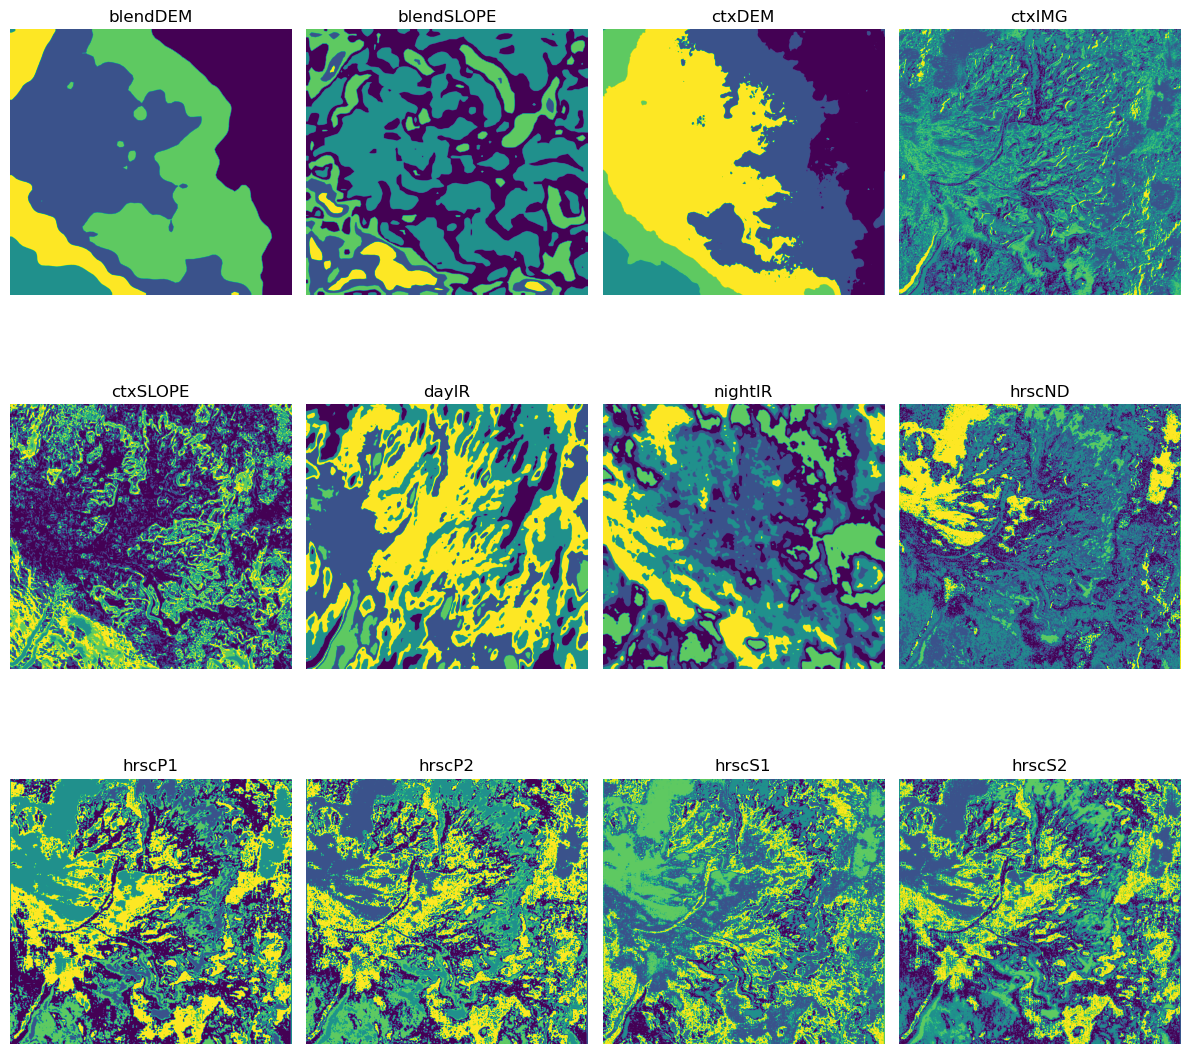

In [4]:
# Set the number of images per row
n_cols = 4
n_rows = len(clustered_imgs) // n_cols + int(len(clustered_imgs) % n_cols > 0)

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 12))

# Loop through the training images and plot them
for i, ax in enumerate(axes.flat):
    if i < len(clustered_imgs):
        img = clustered_imgs[i]  # Clustered images are already 2D arrays
        ax.imshow(img, cmap='viridis')  # You can choose a different colormap if desired
        ax.set_title(training_names[i])
        ax.axis('off')  # Turn off the axes
    else:
        ax.axis('off')  # Turn off any unused subplots

plt.tight_layout()
plt.show()

In [5]:
# Compute the silhouette score for each clustered image
silhouette_scores = [silhouette_score(img.values[0].reshape(-1, 1), clustered_img.ravel(),metric='euclidean', sample_size=10000) for img, clustered_img in zip(training_imgs, clustered_imgs)]

# Sort the silhouette scores and corresponding names in descending order
sorted_scores = sorted(zip(silhouette_scores, training_names), reverse=True)

# Print the silhouette scores in descending order
for score, name in sorted_scores:
    print(f"Silhouette score for {name}: {score}")

Silhouette score for ctxDEM: 0.5720369815826416
Silhouette score for blendDEM: 0.5708889365196228
Silhouette score for blendSLOPE: 0.5630888313590326
Silhouette score for ctxSLOPE: 0.5522311329841614
Silhouette score for nightIR: 0.5321258831968663
Silhouette score for dayIR: 0.5313473399034067
Silhouette score for hrscP1: 0.5306648252461523
Silhouette score for hrscND: 0.5290522052070461
Silhouette score for hrscS1: 0.5269500047540706
Silhouette score for hrscS2: 0.5254037410466551
Silhouette score for hrscP2: 0.5247857116737054
Silhouette score for ctxIMG: 0.5242340219436799


So the DEMs and slope maps have the highest silhoutte scores. After that, the imagery and IR are all around 0.52-0.53.

### Now let's do a K-means clustering analysis using multiple images at the same time

Based on the silhoutte analysis, I think we should definitely include the DEMs and slope maps. I want to exclude the IR images because the alignment is still not perfect with the rest of the images. Besides that, we'll include everything else.

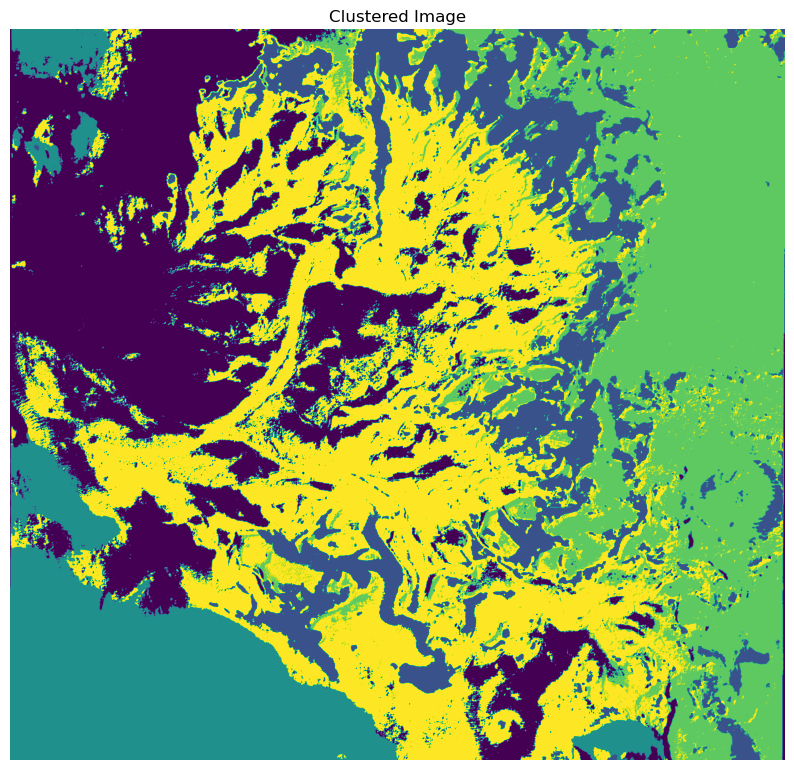

In [6]:
# Define the number of clusters
n_clusters = 5  # Adjust this number based on the desired number of feature classes

# Combine the images into a multi-band image
subset_imgs = [blendDEM, blendSLOPE, ctxDEM, ctxIMG, ctxSLOPE, hrscND, hrscP1, hrscP2, hrscS1, hrscS2]

multi_band_image = np.stack([img.values[0] for img in subset_imgs], axis=-1)

# Flatten the multi-band image into a 2D array where each row represents a pixel and each column represents a band
pixels = multi_band_image.reshape(-1, multi_band_image.shape[-1])

# Apply K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(pixels)

# Reshape the clustered labels back into the original 2D shape
clustered_image = kmeans.labels_.reshape(multi_band_image.shape[:2])

# Plot the clustered image
plt.figure(figsize=(10, 10))
plt.imshow(clustered_image, cmap='viridis')
plt.title('Clustered Image')
plt.axis('off')
plt.show()

## Looks pretty good! Now let's do an elbow curve and silhoutte score analysis to find the optimal number of clusters

In [7]:
# Define the range of cluster numbers to test
cluster_range = range(1, 15)

# Combine the images into a multi-band image
subset_imgs = [blendDEM, blendSLOPE, ctxDEM, ctxIMG, ctxSLOPE, hrscND, hrscP1, hrscP2, hrscS1, hrscS2]
multi_band_image = np.stack([img.values[0] for img in subset_imgs], axis=-1)

# Flatten the multi-band image into a 2D array where each row represents a pixel and each column represents a band
pixels = multi_band_image.reshape(-1, multi_band_image.shape[-1])

# Compute the within-cluster sum of squares (WCSS) for each number of clusters
wcss = []
multi_band_image_kmeans = []
labels_elbow = []
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(pixels)
    wcss.append(kmeans.inertia_)
    multi_band_image_kmeans.append(kmeans.labels_.reshape(multi_band_image.shape[:2]))
    labels_elbow.append(kmeans.labels_)

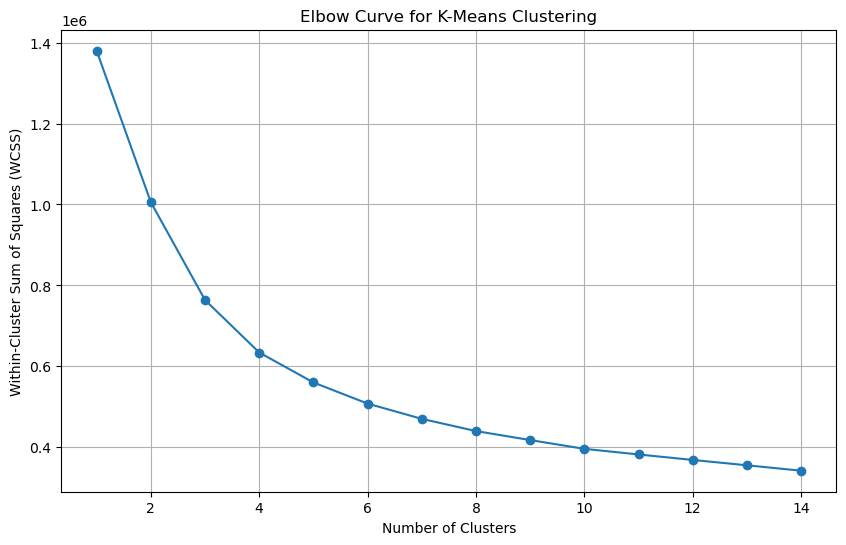

In [8]:
# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Curve for K-Means Clustering')
plt.grid(True)
plt.show()


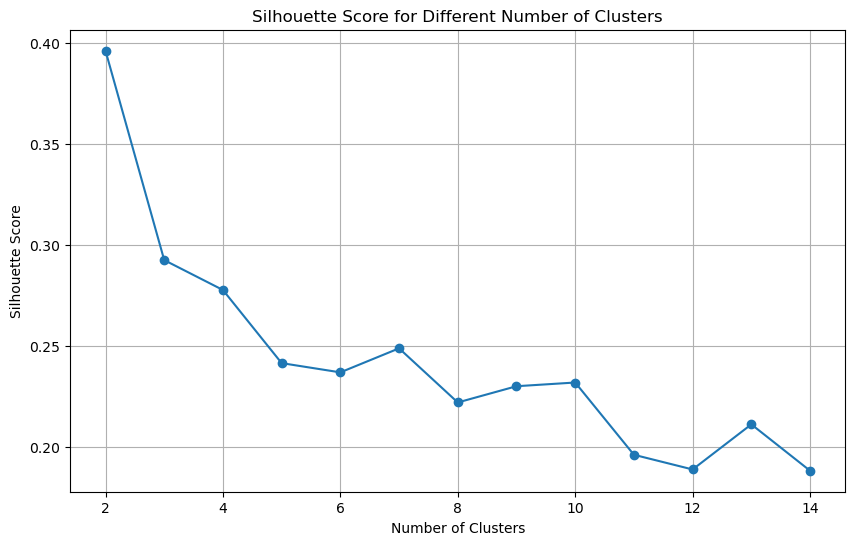

In [12]:
# Define the range of cluster numbers to test
cluster_range = range(2, 15)  # Start from 2 because silhouette score is not defined for 1 cluster

# Flatten the multi-band image into a 2D array where each row represents a pixel and each column represents a band
pixels = multi_band_image.reshape(-1, multi_band_image.shape[-1])

# Compute the silhouette score for each number of clusters
silhouette_scores = []
for k in cluster_range:
    score = silhouette_score(pixels, labels_elbow[k-1], metric='euclidean', sample_size=10000)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Number of Clusters')
plt.grid(True)
plt.show()

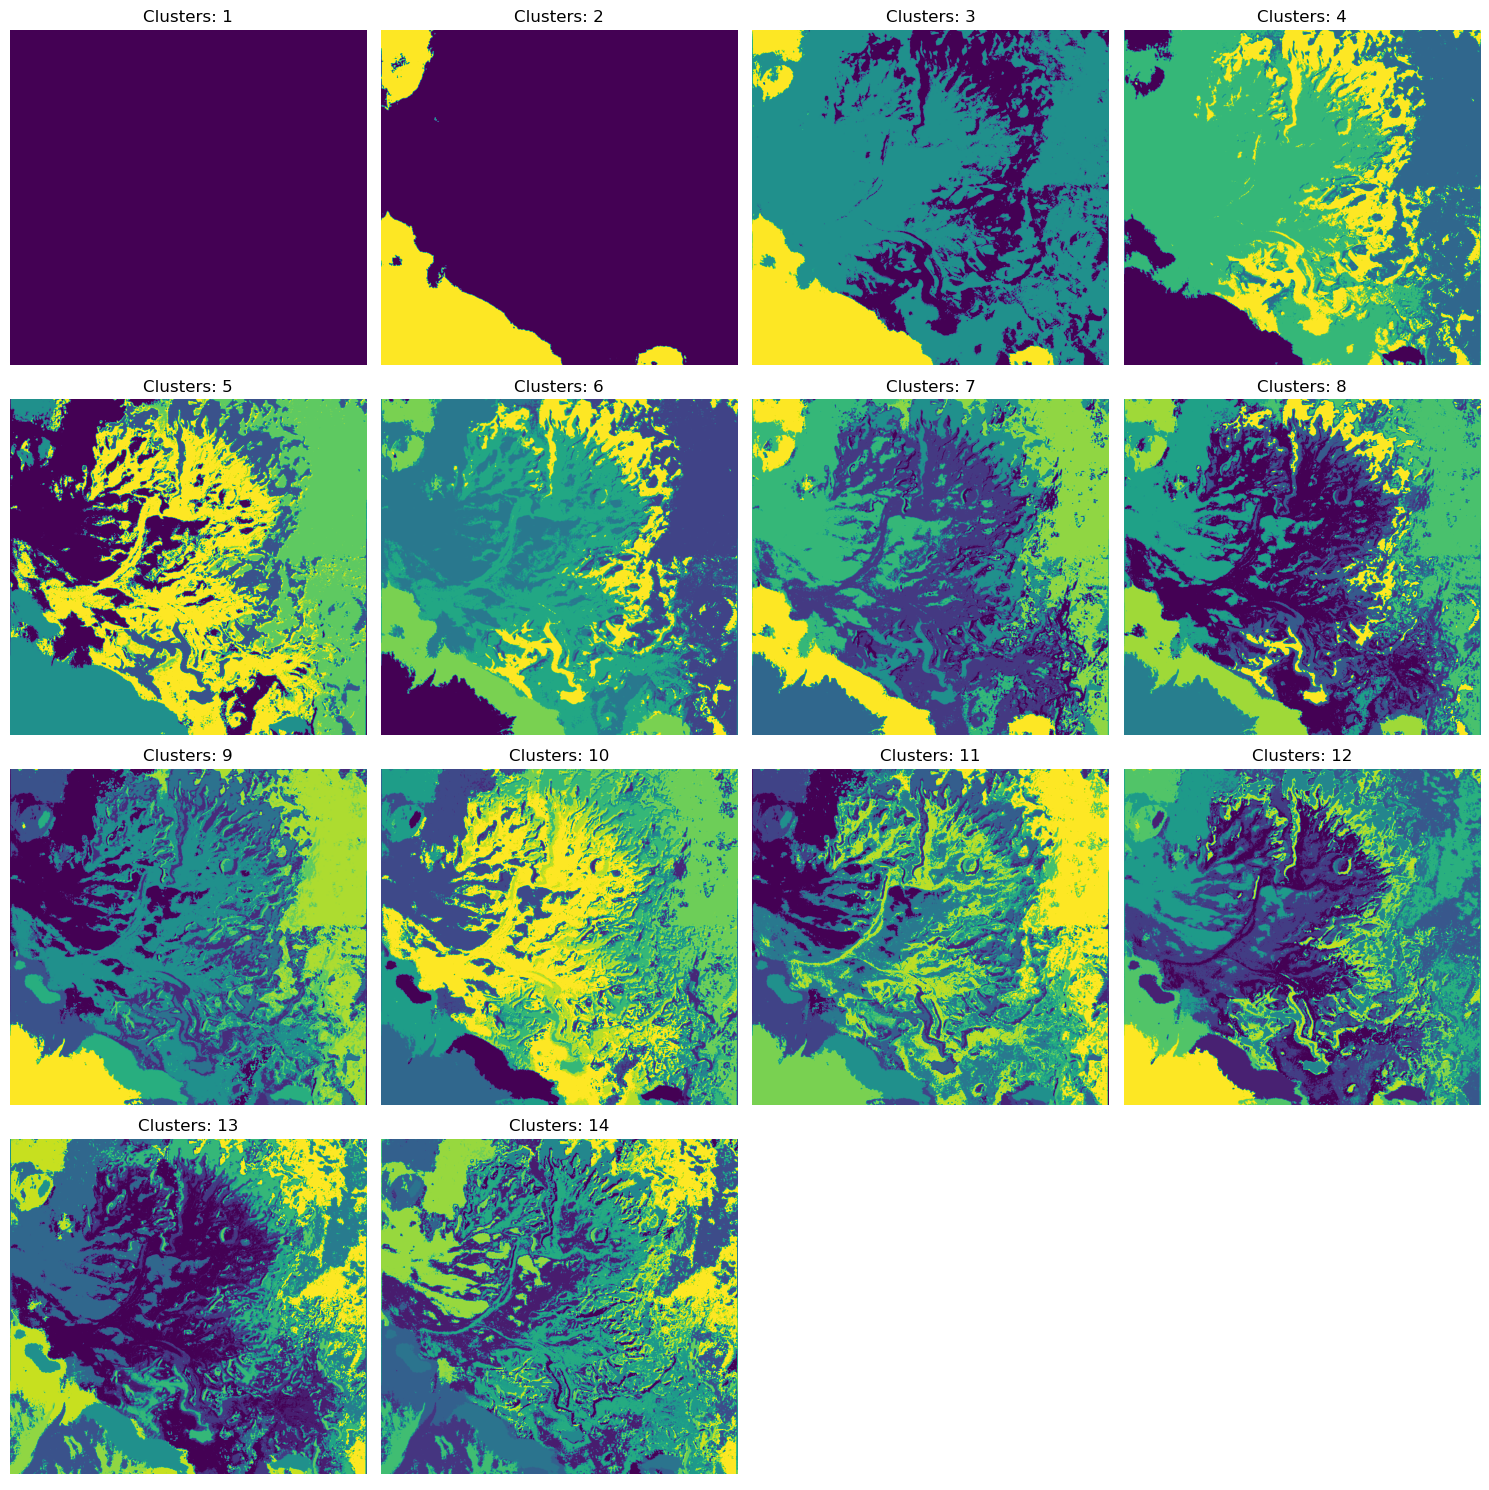

In [14]:
# Set the number of images per row
n_cols = 4
n_rows = len(multi_band_image_kmeans) // n_cols + int(len(multi_band_image_kmeans) % n_cols > 0)

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))

# Loop through the images and plot them
for i, ax in enumerate(axes.flat):
    if i < len(multi_band_image_kmeans):
        img = multi_band_image_kmeans[i]  # Clustered images are already 2D arrays
        ax.imshow(img, cmap='viridis')  # You can choose a different colormap if desired
        ax.set_title(f'Clusters: {i + 1}')
        ax.axis('off')  # Turn off the axes
    else:
        ax.axis('off')  # Turn off any unused subplots

plt.tight_layout()
plt.show()

### Discussion

It looks like the ideal number of clusters is 5-12 based on the silhouette score and elbow curve analysis. This will be useful when we apply our deep learning algorithm and develop a better algorithm for comparison with our label map.

Below is a test calculation for comparing to our label map.

Accuracy: 0.3518
Precision: 0.5851
Recall: 0.3518
F1 Score: 0.3895


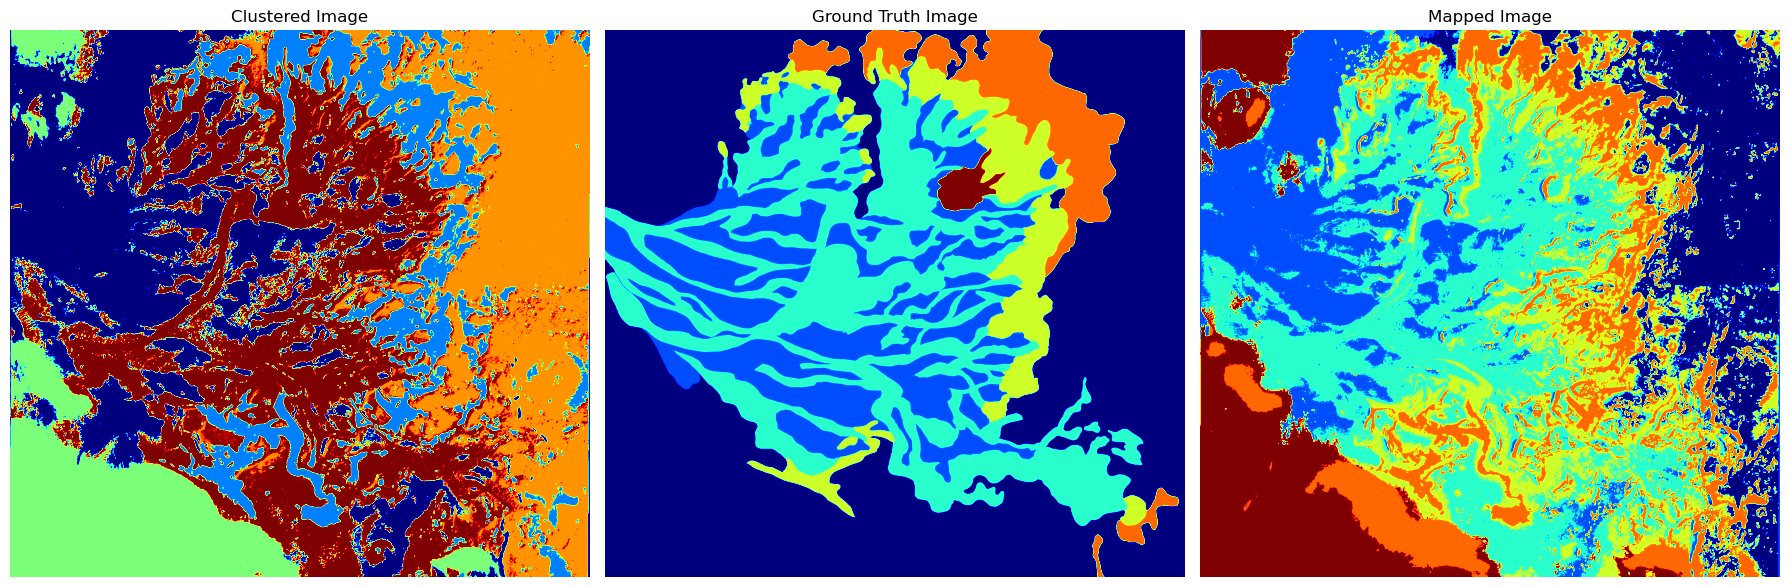

In [42]:

from scipy.cluster.hierarchy import linkage, fcluster

# Compute the contingency matrix (confusion matrix)
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

label_map = rxr.open_rasterio("/Users/tthomas/Desktop/ESS569/MLGEO2024_MarsFans/data/label/validation_map.tif", cache=False)

clustered_image_flat = multi_band_image_kmeans[8].ravel()
ground_truth_labels_flat = label_map.values[0].ravel()

contingency_matrix = confusion_matrix(ground_truth_labels_flat, clustered_image_flat)
# Perform hierarchical clustering on the contingency matrix to combine clusters
Z = linkage(contingency_matrix.T, method='ward')
num_ground_truth_labels = len(np.unique(label_map.values[0]))
combined_clusters = fcluster(Z, t=num_ground_truth_labels, criterion='maxclust')

# Create a mapping from original clusters to combined clusters
cluster_combination_mapping = {i: combined_clusters[i] for i in range(len(combined_clusters))}

# Map the original clusters to the combined clusters
combined_clustered_image_flat = np.vectorize(cluster_combination_mapping.get)(clustered_image_flat)
combined_clustered_image_flat = combined_clustered_image_flat - 1  # Shift the labels to start from 0

# Compute the new contingency matrix with combined clusters
new_contingency_matrix = confusion_matrix(ground_truth_labels_flat, combined_clustered_image_flat)

# Apply the Hungarian algorithm to find the optimal assignment
row_ind, col_ind = linear_sum_assignment(-new_contingency_matrix)

# Create a mapping from combined clusters to ground truth labels
combined_cluster_to_label_mapping = {col: row for row, col in zip(row_ind, col_ind)}

# Map the combined clusters to the ground truth labels
mapped_clusters = np.vectorize(combined_cluster_to_label_mapping.get)(combined_clustered_image_flat)

# Compute evaluation metrics
accuracy = accuracy_score(ground_truth_labels_flat, mapped_clusters)
precision = precision_score(ground_truth_labels_flat, mapped_clusters, average='weighted')
recall = recall_score(ground_truth_labels_flat, mapped_clusters, average='weighted')
f1 = f1_score(ground_truth_labels_flat, mapped_clusters, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the clustered image
axes[0].imshow(clustered_image, cmap='jet')
axes[0].set_title('Clustered Image')
axes[0].axis('off')

# Plot the ground truth image
axes[1].imshow(label_map.values[0], cmap='jet')
axes[1].set_title('Ground Truth Image')
axes[1].axis('off')

# Plot the mapped image
mapped_image = mapped_clusters.reshape(clustered_image.shape)
axes[2].imshow(mapped_image, cmap='jet')
axes[2].set_title('Mapped Image')
axes[2].axis('off')

plt.tight_layout()
plt.show()